# Map Plot Prototype

Point 1: x: 1.2246467991473533e-15, y: 20.0, distance: 20.0, angle: 90.0
Point 2: x: -0.0667498763889522, y: 40.02488875010301, distance: 20.025, angle: 90.19098593171026
Point 3: x: -1.423998501465745, y: 80.72726584493283, distance: 40.725, angle: 91.90985931710274
Point 4: x: -2.5088173795764295, y: 101.04833048243879, distance: 20.35, angle: 93.05577490736438
Point 5: x: -2.7696608077620155, y: 105.39050283115692, distance: 4.350000000000001, angle: 93.43774677078497
Point 6: x: -2.840993612701467, y: 116.0902650542598, distance: 10.699999999999996, angle: 90.38197186342059
Point 7: x: -2.6810042791548034, y: 124.08866510759242, distance: 8.0, angle: 88.85408440973836
Point 8: x: -1.591811507157327, y: 140.40234522905578, distance: 16.35, angle: 86.18028136579451
Point 9: x: 1.133430256600112, y: 160.72039280575646, distance: 20.5, angle: 82.36056273158903


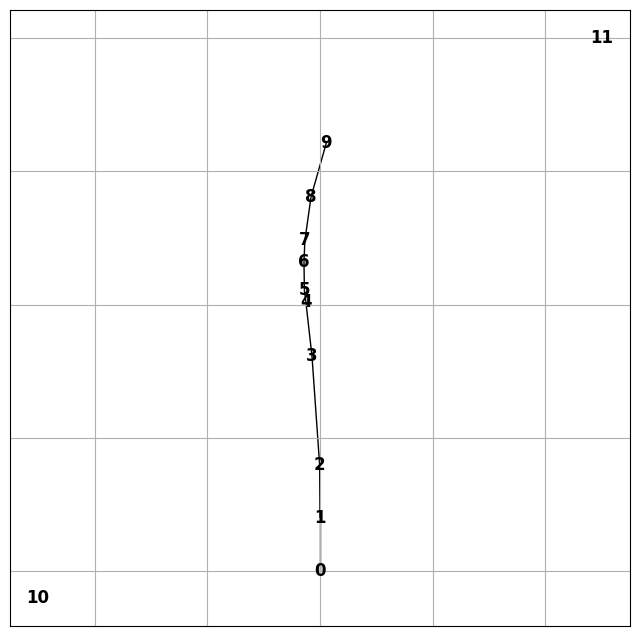

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# Example usage
# A = (15, 0)  # Coordinates of point A
# d = 5.0  # Distance between A and B
# theta = 45  # Angle in degrees

# B = calculate_point_B(A[0], A[1], d, theta)
# print("Coordinates of point B:", B)


class MapGraph:
    def __init__(self, filename="output_graph_print.pdf", figsize=(12, 8)):
        self.HIGHLIGHT_COLOR = "#e31a1c"
        self.VISITED_COLOR = "#5fe382"
        self.NEUTRAL_COLOR = "#1f78b4"
        self.filename = filename
        self.figsize = figsize
        self.graph = nx.Graph()
        self.node_color = []
        self.position = {0: np.array([0, 0])}

        # External data
        self.wheel_distance = 15
        self.raw_map = {
            0: {"left_encoder": 0, "right_encoder": 0},
            1: {"left_encoder": 20, "right_encoder": 20},
            2: {"left_encoder": 40, "right_encoder": 40.05},
            3: {"left_encoder": 80.5, "right_encoder": 81},
            4: {"left_encoder": 100.7, "right_encoder": 101.5},
            5: {"left_encoder": 105, "right_encoder": 105.9},
            6: {"left_encoder": 116.1, "right_encoder": 116.2},
            7: {"left_encoder": 124.3, "right_encoder": 124},
            8: {"left_encoder": 141, "right_encoder": 140},
            9: {"left_encoder": 162, "right_encoder": 160},
        }

        # TODO: Read robot's mapping data
        # self.node_color = ['#1f78b4'] * len(self.graph.nodes)
        self.graph.add_node(0)

    def highlight_node(self, node):
        self.node_color[node] = self.HIGHLIGHT_COLOR

    # def setup(self, params):
    #   gen = nx.fast_gnp_random_graph(params[0], 0.15)
    #   self.graph.add_nodes_from(sorted(gen.nodes(data=True)))
    #   self.graph.add_edges_from(gen.edges(data=True))
    #   self.tree = nx.DiGraph()
    #   self.tree.add_nodes_from(sorted(gen.nodes(data=True)))

    def draw_graph(self):
        fig = plt.figure(figsize=self.figsize)
        fig = nx.draw_networkx(
            G=self.graph,
            pos=self.position,
            node_color=self.node_color,
            node_size=100,
            with_labels=True,
            font_weight="bold",
        )
        plt.grid(visible=True, which="both")

        return fig

    def calculate_point_B(self, x1, y1, distance, theta):
        # Convert angle from degrees to radians
        # theta = np.radians(theta_degrees)

        # Calculate coordinates of B
        x2 = x1 + distance * np.cos(theta)
        y2 = y1 + distance * np.sin(theta)

        return (x2, y2)

    def generate_map_by_encoder(self):
        # TODO: Implement map generation using encoder data
        if len(self.raw_map) <= 1:
            print("Not enough data to generate map")
            return

        # Create PDF file
        self.output = PdfPages(self.filename)

        sim_robot = {
            "x": 0,
            "y": 0,
            "theta": np.radians(90),
        }

        for point in self.raw_map:
            if point == 0:
                continue

            arc_left = (
                self.raw_map[point]["left_encoder"]
                - self.raw_map[point - 1]["left_encoder"]
            )
            arc_right = (
                self.raw_map[point]["right_encoder"]
                - self.raw_map[point - 1]["right_encoder"]
            )

            encoder_average = (arc_left + arc_right) / 2

            # curve_direction = -1 if (arc_left < arc_right) else 1
            # bigger_arc = max(arc_left, arc_right)
            # smaller_arc = min(arc_left, arc_right)

            # curve_radius = (bigger_arc * self.wheel_distance) / (bigger_arc - smaller_arc)
            # curve_angle = (bigger_arc - smaller_arc) / self.wheel_distance
            curve_angle = (-1) * (arc_left - arc_right) / self.wheel_distance

            # sim_robot["theta"] += curve_angle * curve_direction
            sim_robot["theta"] += curve_angle

            # print(f"Arc left: {arc_left}, Arc right: {arc_right}")

            # print(f"np.cos({sim_robot["theta"]} = {np.cos(sim_robot["theta"])}")
            sim_robot["x"], sim_robot["y"] = self.calculate_point_B(
                sim_robot["x"], sim_robot["y"], encoder_average, sim_robot["theta"]
            )

            self.position[point] = np.array([sim_robot["x"], sim_robot["y"]])
            self.graph.add_node(point)
            self.graph.add_edge(point - 1, point)

            print(
                f"Point {point}: x: {sim_robot["x"]}, y: {sim_robot["y"]}, distance: {encoder_average}, angle: {np.degrees(sim_robot['theta'])}"
            )

        self.graph.add_node(self.graph.number_of_nodes())
        self.position[self.graph.number_of_nodes() - 1] = np.array([-50, -10])
        self.graph.add_node(self.graph.number_of_nodes())
        self.position[self.graph.number_of_nodes() - 1] = np.array([50, 200])

        self.output.savefig(self.draw_graph(), bbox_inches="tight")

        # Close PDF file
        self.output.close()


MapGraph(figsize=(8, 8)).generate_map_by_encoder()

In [ ]:
# 1. how to calculate the coordinate of a point B given the coordinates of a point A, the distance AB and the angle
# 2. to get the angle, use velocity(or displacement) of both wheels and the distance between them

import math


def calculate_point_B(x1, y1, d, theta_degrees):
    # Convert angle from degrees to radians
    theta = math.radians(theta_degrees)

    # Calculate coordinates of B
    x2 = x1 + d * math.cos(theta)
    y2 = y1 + d * math.sin(theta)

    return (x2, y2)


# Example usage
A = (15, 0)  # Coordinates of point A
d = 5.0  # Distance between A and B
theta = 45  # Angle in degrees

B = calculate_point_B(A[0], A[1], d, theta)
print("Coordinates of point B:", B)

Coordinates of point B: (18.535533905932738, 3.5355339059327378)


In [ ]:
# Triangle estimative method
import math


def find_point_C(x1, y1, x2, y2, a, b, c):
    # Calculate Δx, Δy, and D for the line equation
    dx = x2 - x1
    dy = y2 - y1
    D = (a**2 - b**2 + dx**2 + dy**2) / 2

    # Ensure that the given distance `c` between A and B is consistent with the coordinates
    calculated_c = math.sqrt(dx**2 + dy**2)
    if not math.isclose(calculated_c, c, rel_tol=1e-9):
        raise ValueError(
            "The given distance c does not match the distance between points A and B"
        )

    # Solve for y in terms of x from the linear equation: x * dx + y * dy = D
    # Rearrange to y = (D - x * dx) / dy, or handle the case where dy == 0.

    # If dy is zero, the line is vertical
    if dy == 0:
        # In this case, x is fixed, and we can solve for y using (x - x1)^2 + (y - y1)^2 = b^2
        x = D / dx
        term = b**2 - (x - x1) ** 2
        if term < 0:
            raise ValueError("No solution exists for point C with the given distances.")
        y1_solution = y1 + math.sqrt(term)
        y2_solution = y1 - math.sqrt(term)
        return [(x, y1_solution), (x, y2_solution)]
    else:
        # Define a quadratic function to solve for x from the circle equation
        # Substituting y in terms of x gives a quadratic in x
        A = dx**2 + dy**2
        B = -2 * dx * D
        C_term = D**2 - dy**2 * b**2

        # Solve for x using the quadratic formula
        discriminant = B**2 - 4 * A * C_term
        if discriminant < 0:
            raise ValueError("No solution exists for point C with the given distances.")

        # Two possible solutions for x
        x1_solution = (-B + math.sqrt(discriminant)) / (2 * A)
        x2_solution = (-B - math.sqrt(discriminant)) / (2 * A)

        # Calculate the corresponding y values for each x solution
        y1_solution = (D - x1_solution * dx) / dy
        y2_solution = (D - x2_solution * dx) / dy

        # Return the two possible points for C
        return [(x1_solution, y1_solution), (x2_solution, y2_solution)]


# Example usage
A = (0, 0)  # Coordinates of point A
B = (15, 0)  # Coordinates of point B
a = 213.9  # Distance BC
b = 200.0  # Distance AC
c = 15.0  # Distance AB

try:
    points_C = find_point_C(A[0], A[1], B[0], B[1], a, b, c)
    print("Possible coordinates for point C:", points_C)
except ValueError as e:
    print("Error:", e)

Possible coordinates for point C: [(199.27366666666663, 17.029555872724163), (199.27366666666663, -17.029555872724163)]
